In [231]:
import numpy as np
import pandas as pd 
import cv2
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam,Adadelta
from keras.layers.core import Dropout
from keras.layers.pooling import AveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from keras import Input
from keras.callbacks import ModelCheckpoint
%matplotlib inline

In [3]:
# Dataset ---> Multi-class Weather Dataset for Image Classification
# Link --> https://data.mendeley.com/datasets/4drtyfjtfy/1
root_dir = "/home/pawan/Downloads/dataset2/"

In [175]:
images = []
labels = []
temp = re.compile("([a-zA-Z]+)([0-9]+)") 
for file in os.listdir(root_dir):
    try:
        img = cv2.imread(root_dir+file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(128,128),interpolation=cv2.INTER_AREA)
        label = temp.match(file).groups()[0]
        images.append(img)
        labels.append(label)
    except:
        print("Unsupported Format")

Unsupported Format
Unsupported Format


In [176]:
print(np.shape(images))
print(np.shape(labels))

(1123, 128, 128, 3)
(1123,)


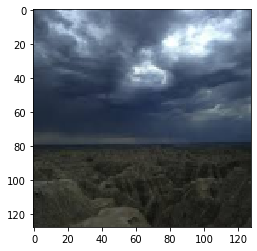

In [237]:
plt.imshow(images[1])

In [178]:
# Total classes
np.unique(labels,return_counts=True)[0]

array(['cloudy', 'rain', 'shine', 'sunrise'], dtype='<U7')

In [179]:
dictionary  = {'cloudy':0, 'rain':1, 'shine':2, 'sunrise': 3}

In [180]:
# One hot encode
labels = [dictionary.get(n) for n in labels]
labels = to_categorical(labels,num_classes=4)

In [181]:
labels[0]

array([0., 0., 1., 0.], dtype=float32)

In [209]:
# VGG model with Imagenet weights
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))

#Adding custom layers to VGG16 

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

# Use the existing Imagenet weights for VGG16 --> To reduce training time
for layer in baseModel.layers:
    layer.trainable = False

# Finally add custom model to final layer of VGG16    
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0  

In [204]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [205]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_val))
print(np.shape(y_train))
print(np.shape(y_test))
print(np.shape(y_val))

(718, 128, 128, 3)
(225, 128, 128, 3)
(180, 128, 128, 3)
(718, 4)
(225, 4)
(180, 4)


In [210]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

In [211]:
model.fit(np.array(X_train),np.array(y_train),
          batch_size=40,
          verbose=1,
          epochs=20,
          validation_data=(np.array(X_val), np.array(y_val)))

Train on 718 samples, validate on 180 samples
Epoch 1/20
718/718 [==============================] - 92s 128ms/step - loss: 3.9636 - accuracy: 0.5557 - val_loss: 0.7925 - val_accuracy: 0.8444
Epoch 2/20
718/718 [==============================] - 92s 128ms/step - loss: 1.3345 - accuracy: 0.8217 - val_loss: 0.5264 - val_accuracy: 0.8833
Epoch 3/20
718/718 [==============================] - 91s 126ms/step - loss: 0.7161 - accuracy: 0.8510 - val_loss: 0.3064 - val_accuracy: 0.9000
Epoch 4/20
718/718 [==============================] - 90s 126ms/step - loss: 0.4194 - accuracy: 0.9081 - val_loss: 0.3416 - val_accuracy: 0.9000
Epoch 5/20
718/718 [==============================] - 90s 126ms/step - loss: 0.4010 - accuracy: 0.9053 - val_loss: 0.2331 - val_accuracy: 0.9167
Epoch 6/20
718/718 [==============================] - 91s 127ms/step - loss: 0.3478 - accuracy: 0.9206 - val_loss: 0.2381 - val_accuracy: 0.9167
Epoch 7/20
718/718 [==============================] - 90s 126ms/step - loss: 0.2470 

In [212]:
y_pred = model.predict(np.array(X_test))
Y_pred = [np.argmax(res) for res in y_pred]
Y_test = [np.argmax(res) for res in y_test]

In [233]:
print("Test Accuracy = ",accuracy_score(Y_pred,Y_test))

Test Accuracy =  0.9155555555555556


In [234]:
print(confusion_matrix(Y_pred,Y_test))

[[66  1  2  3]
 [ 0 37  3  0]
 [ 2  0 45  2]
 [ 0  0  6 58]]


In [235]:
print(classification_report(Y_pred,Y_test))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        72
           1       0.97      0.93      0.95        40
           2       0.80      0.92      0.86        49
           3       0.92      0.91      0.91        64

    accuracy                           0.92       225
   macro avg       0.92      0.92      0.92       225
weighted avg       0.92      0.92      0.92       225

